In [1]:
cd /Users/quinnunderriner/Desktop/Work/missing_middle/zillow

/Users/quinnunderriner/Desktop/Work/missing_middle/zillow


In [2]:
import numpy as np
import pandas as pd
import zipfile         
import os
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns 
import DateTime
import re 
import cpi
import warnings
from cols_to_keep import * #small python file i made just with long list of dates we don't need 
warnings.filterwarnings('ignore')

#pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option("display.max_columns", 330)

From Zillow: the change in low and high tier values for home sales by county (ideally from 2010-2019 if we have it), 10 MSAs above, and also a statewide graph.

In [27]:
#read in data (data from here https://www.zillow.com/research/data/, top input, all home low and high tier time series)
county_low_tier = pd.read_csv("County_zhvi_uc_sfrcondo_tier_0.0_0.33_sm_sa_mon.csv")
county_high_tier = pd.read_csv("County_zhvi_uc_sfrcondo_tier_0.67_1.0_sm_sa_mon.csv")
#filter for california 
county_low_tier = county_low_tier[county_low_tier.StateName == "CA"]
county_high_tier = county_high_tier[county_high_tier.StateName == "CA"]
#make flags for the tiers 
county_low_tier["Tier"] = "Low Tier"
county_high_tier["Tier"] = "High Tier"
#merge data together for all california 
county_home_value = pd.concat([county_low_tier,county_high_tier])
#filter out columns with price data before 2010 
county_home_value = county_home_value[cols_to_keep]

In [4]:
county_home_value_melt = county_home_value.drop(columns=["RegionID","SizeRank",
                                                     "RegionType","StateName","State","StateCodeFIPS",
                                                     "MunicipalCodeFIPS"])

In [5]:
county_home_value_melt = county_home_value_melt.melt(["Tier","Metro","RegionName",])

In [6]:
county_home_value_melt = county_home_value_melt.rename(columns={"variable":"Date","value":"House Cost"})

In [7]:
county_home_value_melt['Date'] = pd.to_datetime(county_home_value_melt['Date'])

In [8]:
def adjust_for_CPI(date,house_cost):
    if date.year == 2010:
        return cpi.inflate(house_cost, 2010)
    if date.year == 2011:
        return cpi.inflate(house_cost, 2011)
    if date.year == 2012:
        return cpi.inflate(house_cost, 2012)
    if date.year == 2013:
        return cpi.inflate(house_cost, 2013)
    if date.year == 2014:
        return cpi.inflate(house_cost, 2014)
    if date.year == 2015:
        return cpi.inflate(house_cost, 2015)
    if date.year == 2016:
        return cpi.inflate(house_cost, 2016)
    if date.year == 2017:
        return cpi.inflate(house_cost, 2017)
    if date.year == 2018:
        return cpi.inflate(house_cost, 2018)
    if date.year == 2019:
        return cpi.inflate(house_cost, 2019)
    if date.year == 2020:
        return house_cost

In [9]:
county_home_value_melt['House_Cost_(2019)'] = county_home_value_melt[["Date","House Cost"]].apply(lambda x: adjust_for_CPI(*x), axis=1)

### Graph all California 

Text(0.5, 1.0, 'Changes in California Housing Cost')

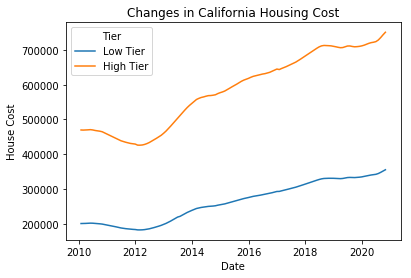

In [10]:
sns.lineplot(data=county_home_value_melt, x="Date", y="House Cost",hue="Tier",ci=None).set_title('Changes in California Housing Cost')


Text(0.5, 1.0, 'Changes in California Housing Cost (2020$))')

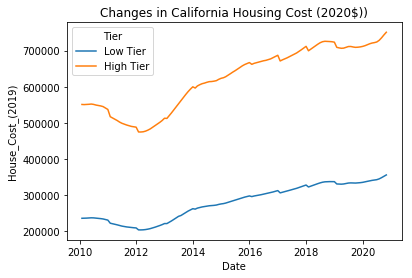

In [11]:
sns.lineplot(data=county_home_value_melt, x="Date", y="House_Cost_(2019)",hue="Tier",ci=None).set_title('Changes in California Housing Cost (2020$))')


###  Graph top 10 MSA 

In [12]:
#load in top 10 msas
msa = pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/msa.csv")
msa = msa[["MSA_NAME","COUNTIES"]]
top_10_msa = ['Riverside-San Bernardino-Ontario','San Jose-Sunnyvale-Santa Clara',
              'San Francisco-Redwood City-South San Francisco','Oakland-Hayward-Berkeley',
              'Los Angeles-Long Beach-Glendale','Anaheim-Santa Ana-Irvine','San Diego-Carlsbad',
               'Sacramento--Roseville--Arden-Arcade','Fresno','Oxnard-Thousand Oaks-Ventura']
msa = msa[msa.MSA_NAME.isin(top_10_msa)]
#need to expand mapping 
msa = msa.drop('COUNTIES', axis=1).join(
  msa['COUNTIES'].str.split(',', expand=True).stack()
    .reset_index(level=1,drop=True).rename('COUNTIES'))
msa['COUNTIES'] = msa['COUNTIES'] + " County" 
msa = msa.rename(columns={"COUNTIES":"County_Name","MSA_NAME":"Metro"})#rename for clean merge

# merge and subset data to just contain top 10 MSAs 
top_10_msa = msa.merge(county_home_value_melt, on="Metro",how="left")

Text(0.5, 1.0, 'Changes in Housing Cost California top 10 MSAs ($2020))')

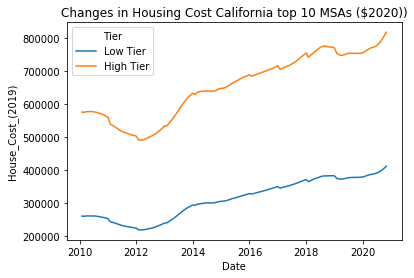

In [13]:
sns.lineplot(data=top_10_msa, x="Date", y="House_Cost_(2019)",hue="Tier",ci=None).set_title('Changes in Housing Cost California top 10 MSAs ($2020))')

### Graph Counties 

In [14]:
county_home_value_melt.RegionName.unique()

array(['Los Angeles County', 'San Diego County', 'Orange County',
       'Riverside County', 'San Bernardino County', 'Santa Clara County',
       'Alameda County', 'Sacramento County', 'Contra Costa County',
       'Fresno County', 'Kern County', 'Ventura County',
       'San Francisco County', 'San Mateo County', 'San Joaquin County',
       'Stanislaus County', 'Sonoma County', 'Tulare County',
       'Santa Barbara County', 'Monterey County', 'Solano County',
       'Placer County', 'San Luis Obispo County', 'Santa Cruz County',
       'Merced County', 'Marin County', 'Butte County', 'Yolo County',
       'El Dorado County', 'Shasta County', 'Imperial County',
       'Kings County', 'Madera County', 'Napa County', 'Humboldt County',
       'Nevada County', 'Sutter County', 'Mendocino County',
       'Yuba County', 'Lake County', 'Tehama County', 'Tuolumne County',
       'San Benito County', 'Calaveras County', 'Siskiyou County',
       'Amador County', 'Lassen County', 'Del Norte 

In [15]:
lake_county_home_value_melt = county_home_value_melt[county_home_value_melt.RegionName=="Lake County"]
LA_county_home_value_melt = county_home_value_melt[county_home_value_melt.RegionName=="Los Angeles County"]

Text(0.5, 1.0, 'Changes in Housing Cost Los Angeles ($2020))')

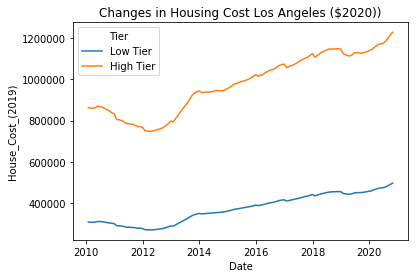

In [16]:
sns.lineplot(data=LA_county_home_value_melt, x="Date", y="House_Cost_(2019)",hue="Tier",ci=None).set_title('Changes in Housing Cost Los Angeles ($2020))')

Text(0.5, 1.0, 'Changes in Housing Cost Lake County ($2020))')

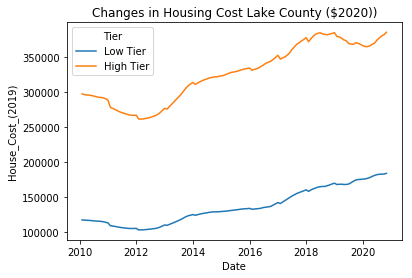

In [17]:
sns.lineplot(data=lake_county_home_value_melt, x="Date", y="House_Cost_(2019)",hue="Tier",ci=None).set_title('Changes in Housing Cost Lake County ($2020))')

### HMDA data 

In [18]:
#hmda = pd.read_csv("2019_public_lar_csv.csv") dont want to run this again because file so big, ~ 7GB
#hmda_ca.to_csv("CA_only_2019_public_lar_csv.csv")
#hmda_ca = pd.read_csv("hmda_ca")
#filter for california
#hmda_ca = hmda[hmda.state_code=="CA"]
# data from here for 2019 https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2019
# from here for 2010 https://www.consumerfinance.gov/data-research/hmda/historic-data/?geo=ca&records=originated-records&field_descriptions=labels

#2019 data dictionary: https://ffiec.cfpb.gov/documentation/2019/lar-data-fields/
#2010 data dictionary: https://files.consumerfinance.gov/hmda-historic-data-dictionaries/lar_record_codes.pdf

In [19]:
#read in 2019 data
hmda_ca_19 = pd.read_csv("CA_only_2019_public_lar_csv.csv")
#read in 2010 data 
hmda_ca_10 = pd.read_csv("hmda_2010_ca_originated-records_labels.csv")
#read in AMI bands 
county_level_AMI = pd.read_csv("year_county_AMI.csv")

MSA_level_AMI = pd.read_csv("year_MSA_AMI.csv")

#FIPS codes. https://github.com/kjhealy/fips-codes 
county_fips = pd.read_csv("county_fips_master.csv", encoding='latin-1')
county_fips = county_fips[county_fips["state_abbr"]=="CA"]
county_fips = county_fips[county_fips["state_abbr"]=="CA"]
county_fips = county_fips.rename(columns={"fips":"county_code"})

In [20]:
county_level_AMI_2010 = county_level_AMI[county_level_AMI.year == 2010]
county_level_AMI_2019 = county_level_AMI[county_level_AMI.year == 2019]

county_level_AMI_2019 = county_level_AMI_2019.rename(columns={"County_Name":"county_name"})
county_level_AMI_2010 = county_level_AMI_2010.rename(columns={"County_Name":"county_name"})


#### Want to filter data for owner occupied princple residences, home purchases (not refinance), and for first liens that are actually disbursed


In [50]:
hmda_ca_10 = hmda_ca_10[hmda_ca_10.property_type == 1] #single family home 
hmda_ca_10 = hmda_ca_10[hmda_ca_10.owner_occupancy == 1] #owner occupied
hmda_ca_10 = hmda_ca_10[hmda_ca_10.loan_purpose == 1]#loan for home purchase 
hmda_ca_10 = hmda_ca_10[hmda_ca_10.action_taken == 1] #loan actually disbursed 
hmda_ca_10 = hmda_ca_10[hmda_ca_10.lien_status == 1] #1st lien 

In [44]:
hmda_ca_19 = hmda_ca_19[hmda_ca_19.derived_loan_product_type.isin(["Conventional:First Lien","FHA:First Lien",
                                           "VA:First Lien","FSA/RHS:First Lien"])] #first lien types 
hmda_ca_19 = hmda_ca_19[hmda_ca_19.business_or_commercial_purpose == 2] #Not primarily for a business or commercial purpose
hmda_ca_19 = hmda_ca_19[hmda_ca_19.loan_purpose == 1] #Home purchase
hmda_ca_19 = hmda_ca_19[hmda_ca_19.derived_dwelling_category == "Single Family (1-4 Units):Site-Built"] #dwelling type 
hmda_ca_19 = hmda_ca_19[hmda_ca_19.occupancy_type == 1]  #Principal residence
hmda_ca_19 = hmda_ca_19[hmda_ca_19.action_taken == 1]  #loan actually originated 


So then i need to calucate value of home affordable to someone with the median income (iirc can just assume family of four b/c hmda data is not goint to give you family type).

so then once data is filtered like above to loan values (i can assume, i think, that loan values represent 808% of house values), i can figure out how many houses were sold in a given year in a given county that would affordable to someone in 80-120% AMI 
                                                                                    

In [53]:
hmda_ca_sub = hmda_ca_19[["loan_amount","property_value","income","county_code"]]
hmda_ca_10_sub = hmda_ca_10[["loan_amount_000s","applicant_income_000s","county_name","county_code"]]

#little data cleaning 
hmda_ca_10_sub["loan_amount"] = hmda_ca_10_sub["loan_amount_000s"] *1000
hmda_ca_10_sub["applicant_income"] = hmda_ca_10_sub["applicant_income_000s"] *1000
hmda_ca_10_sub = hmda_ca_10_sub.drop(columns=["applicant_income_000s","loan_amount_000s"])

hmda_ca_sub["income"] = hmda_ca_sub["income"] *1000

In [54]:
#merge county name for 2019 data 
hmda_ca_sub = hmda_ca_sub.dropna()
hmda_ca_sub.county_code = hmda_ca_sub.county_code.astype(int)
hmda_ca_sub = hmda_ca_sub.merge(county_fips,on="county_code",how="left")

In [55]:
#merge on ami data for 2019 data
hmda_ca_sub = hmda_ca_sub.merge(county_level_AMI_2019,on="county_name",how="left")
#merge on ami data for 2010 data
hmda_ca_10_sub = hmda_ca_10_sub.merge(county_level_AMI_2010,on="county_name",how="left")


In [56]:
hmda_ca_sub['80-120%AMI_HH'] = np.where((hmda_ca_sub["income"] >= hmda_ca_sub["80%_AMI"])&(hmda_ca_sub["income"] <= hmda_ca_sub["120%_AMI"]), 1, 0)
hmda_ca_10_sub['80-120%AMI_HH'] = np.where((hmda_ca_10_sub["applicant_income"] >= hmda_ca_10_sub["80%_AMI"])&(hmda_ca_10_sub["applicant_income"] <= hmda_ca_10_sub["120%_AMI"]), 1, 0)

In [57]:
hmda_ca_sub["80-120%AMI_HH"].sum() / len(hmda_ca_sub["80-120%AMI_HH"])

0.2316457854771243

In [58]:
hmda_ca_10_sub["80-120%AMI_HH"].sum() / len(hmda_ca_10_sub["80-120%AMI_HH"])

0.2635482246762244

In [59]:
0.20955884547525183 - 0.2075293671226952

0.002029478352556624

In [60]:
hmda_ca_sub_mid = hmda_ca_sub[hmda_ca_sub["80-120%AMI_HH"]==1]
hmda_ca_10_sub_mid = hmda_ca_10_sub[hmda_ca_10_sub["80-120%AMI_HH"]==1]

In [61]:
hmda_ca_sub_mid.loan_amount.mean()

362875.4023585791

In [62]:
hmda_ca_10_sub_mid.loan_amount.mean()

262527.07710871066

In [63]:
hmda_ca_sub_mid.groupby("county_name").size() - hmda_ca_10_sub_mid.groupby("county_name").size()

county_name
Alameda County            -547.00
Butte County               301.00
Contra Costa County        867.00
El Dorado County           217.00
Fresno County              579.00
Humboldt County             97.00
Imperial County            -10.00
Kern County                620.00
Kings County               196.00
Los Angeles County       -6646.00
Madera County                 nan
Marin County               -26.00
Merced County              154.00
Monterey County           -250.00
Napa County                -45.00
Orange County            -1086.00
Placer County              271.00
Riverside County           -98.00
Sacramento County         2817.00
San Bernardino County      849.00
San Diego County           237.00
San Francisco County      -327.00
San Joaquin County         319.00
San Luis Obispo County      98.00
San Mateo County          -469.00
Santa Barbara County       227.00
Santa Clara County       -1424.00
Santa Cruz County          -35.00
Shasta County                 nan
So